In [1]:
import os
import sys

if os.getcwd().endswith("notebooks"):
    os.chdir("..")

sys.path.append(os.path.abspath("./"))

print(f"Current work directory: {os.getcwd()}")

Current work directory: C:\Users\yyyyx\Work\OC43_machine_learning\Regression_Modeling_of_OC43_Coronavirus_Viral_Burden_from_Host_Single-cell_Transcriptomes_Using_Explainable_Machine_Learning


In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import pairwise_distances
import matplotlib.lines as mlines
import scripts.plotting as pl

C:\Users\yyyyx\miniconda3\envs\sc_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
adata = sc.read_h5ad('./Data/h5ad/Visualize.h5ad')

In [19]:
df = pd.read_csv('./CSV/Bulk-seq/GSE252692_converted.csv', index_col='Gene_symbol')

In [20]:
df_t = df.transpose().copy()

In [21]:
adata_bulk = sc.AnnData(df_t.values.copy().astype(float))
adata_bulk.obs_names = df_t.index
adata_bulk.var_names = df_t.columns

adata_bulk.var_names_make_unique()

sc.pp.normalize_total(adata_bulk, target_sum=1e4)
sc.pp.log1p(adata_bulk)

In [22]:
adata_bulk_mapped = adata_bulk.copy()

ref_genes = adata.var_names

missing_genes = [g for g in ref_genes if g not in adata_bulk_mapped.var_names]
if len(missing_genes) > 0:
    zero_df = pd.DataFrame(0, index=adata_bulk_mapped.obs_names, columns=missing_genes)
    adata_missing = sc.AnnData(zero_df)
    adata_bulk_mapped = sc.concat([adata_bulk_mapped, adata_missing], axis=1)

adata_bulk_mapped = adata_bulk_mapped[:, ref_genes].copy()

adata.var_names = adata.var_names.str.lower()
adata_bulk_mapped.var_names = adata_bulk_mapped.var_names.str.lower()

sc.tl.ingest(adata_bulk_mapped, adata, obs='infection_group', embedding_method='umap')

print("✅ Bulk data projected onto SC UMAP space.")

C:\Users\yyyyx\miniconda3\envs\sc_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\yyyyx\miniconda3\envs\sc_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Bulk data projected onto SC UMAP space.


In [23]:
sc.tl.diffmap(adata)

root_group = 'No infection'
mask = adata.obs['infection_group'] == root_group
cells_idx = np.where(mask)[0]
cells_coords = adata.obsm['X_pca'][mask]

centroid = np.mean(cells_coords, axis=0).reshape(1, -1)

distances = pairwise_distances(cells_coords, centroid)
closest_idx_local = np.argmin(distances)
root_cell_idx = cells_idx[closest_idx_local]

adata.uns['iroot'] = root_cell_idx
print(f"✅ Root set to the representative (centroid) cell in '{root_group}' (Index: {adata.uns['iroot']})")

sc.tl.dpt(adata)
print("✅ Pseudotime calculation (DPT) completed.")

✅ Root set to the representative (centroid) cell in 'No infection' (Index: 1221)
✅ Pseudotime calculation (DPT) completed.


In [24]:
def extract_hpi(sample_name):
    if 'uninfected' in sample_name:
        return 'Mock'
    
    parts = sample_name.split('_')
    for part in parts:
        if 'hpi' in part:
            return part
            
    return None

adata_bulk_mapped.obs['hpi'] = adata_bulk_mapped.obs.index.map(extract_hpi)

print(adata_bulk_mapped.obs[['infection_group', 'hpi']].head(10))

                   infection_group    hpi
01_uninfected_rep1   Low infection   Mock
02_OC43_3hpi_rep1    Low infection   3hpi
03_OC43_6hpi_rep1    Low infection   6hpi
04_OC43_9hpi_rep1    Low infection   9hpi
05_OC43_12hpi_rep1  High infection  12hpi
06_OC43_18hpi_rep1  High infection  18hpi
07_OC43_24hpi_rep1  High infection  24hpi
08_OC43_30hpi_rep1  High infection  30hpi
17_uninfected_rep3   Low infection   Mock
19_OC43_3hpi_rep3    Low infection   3hpi


In [25]:
bulk_order_list = ['Mock', '3hpi', '6hpi', '9hpi', '12hpi', '18hpi', '24hpi', '30hpi']
bulk_rainbow = {
    'Mock': '#696969', '3hpi': '#9400D3', '6hpi': '#4B0082', '9hpi': '#0000FF',
    '12hpi': '#008000', '18hpi': '#FFD700', '24hpi': '#FF8C00', '30hpi': '#FF0000'
}

Computing Directed PAGA Trajectory...


C:\Users\yyyyx\Work\OC43_machine_learning\Regression_Modeling_of_OC43_Coronavirus_Viral_Burden_from_Host_Single-cell_Transcriptomes_Using_Explainable_Machine_Learning\scripts\plotting.py:716: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_temp, resolution=paga_resolution, key_added='leiden_paga')


PAGA Trajectory plot saved to: ./Plot/fig_trajectory_paga


(<Figure size 3600x3000 with 1 Axes>,
 <Axes: title={'center': 'Trajectory'}, xlabel='UMAP1', ylabel='UMAP2'>)

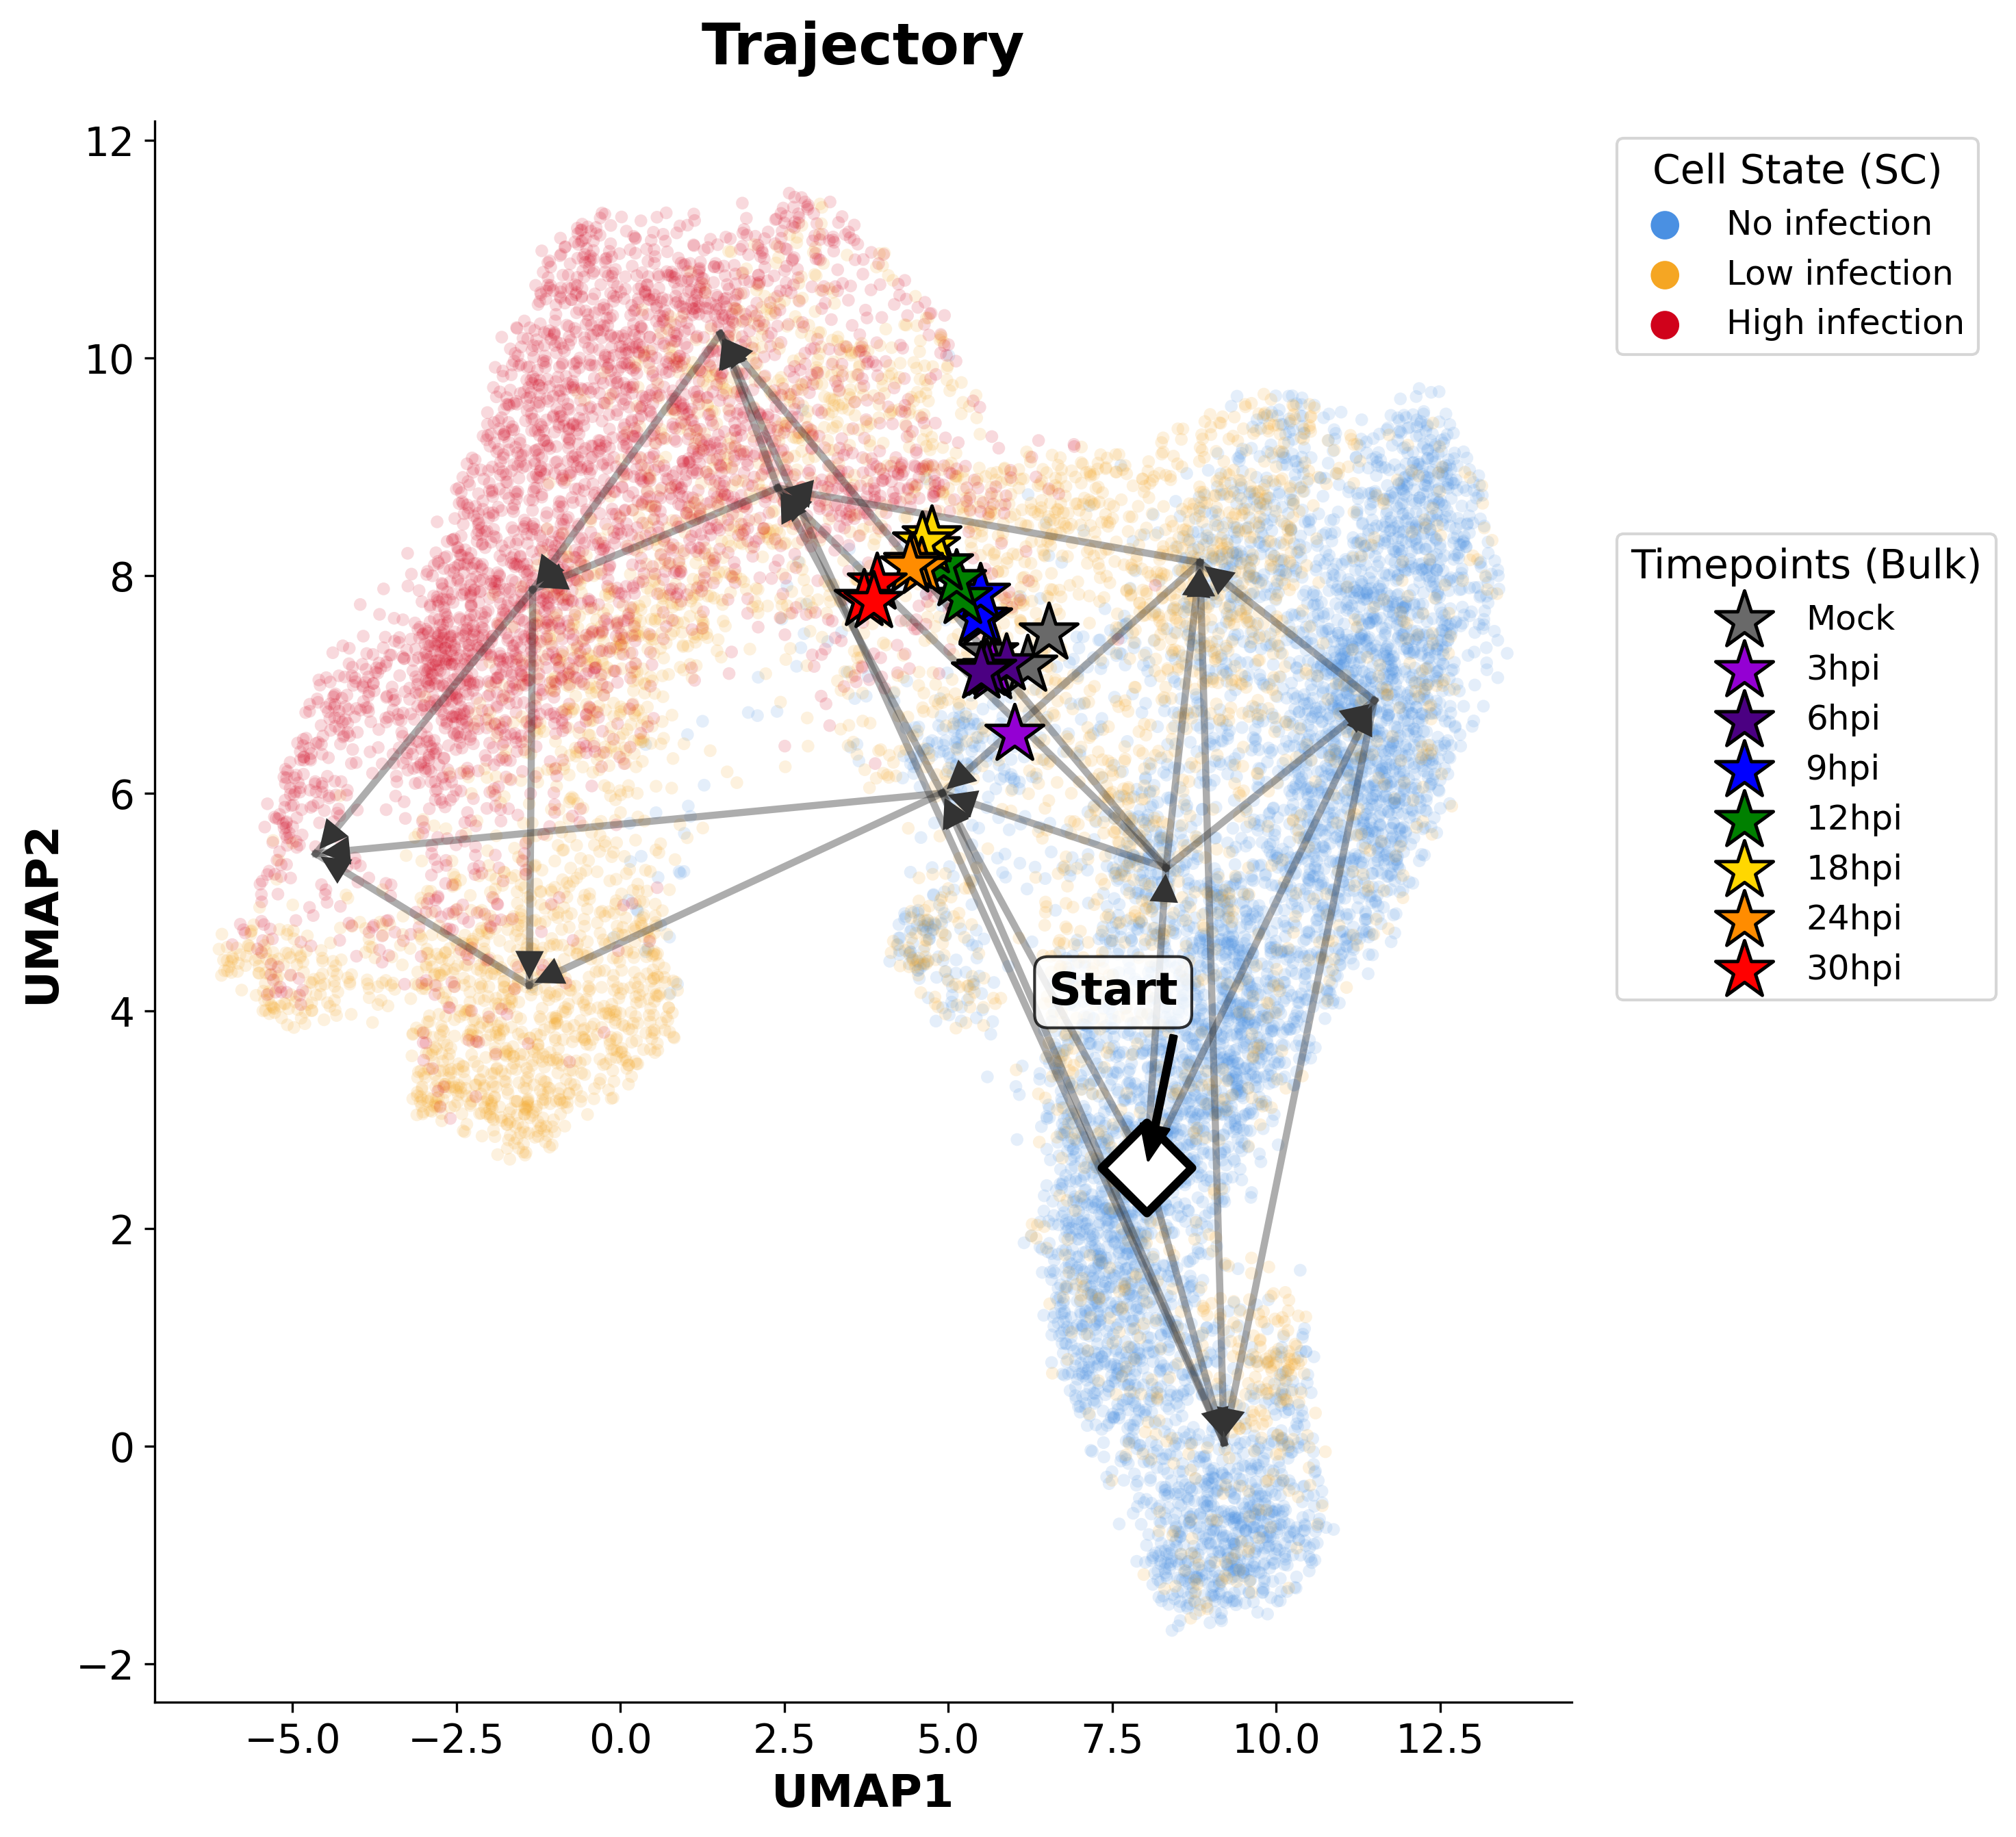

In [26]:
pl.plot_directed_paga_trajectory(
    adata_sc=adata, 
    adata_bulk=adata_bulk_mapped, 
    sc_group_col='infection_group', 
    sc_pseudotime_key='dpt_pseudotime',
    bulk_group_col='hpi',       
    bulk_colors=bulk_rainbow, 
    bulk_order=bulk_order_list,
    paga_resolution=1.0,
    threshold=0.05,
    title = 'Trajectory',
    save_path='./Plot/fig_trajectory_paga'
)

In [27]:
import session_info

session_info.show()